# CNN 불러오기

## 실습 개요

1) **실습 목적**

이번 실습에서는 다양한 CNN 모델들을 torch.hub에서 불러와 보게 됩니다. 다양한 구조를 가진 모델들이 각 layer를 거칠 때마다 어떤 출력값을 가지게 되는지를 직접 확인해보는 과정을 통해서 모델 구조에 대한 이해를 높일 수 있습니다.



2) **수강 목표**

- torch.hub를 통해서 대표적인 backbone들을 불러올 수 있다
- 각 레이어를 거친 후 어떤 출력값을 가지게 되는지 알 수 있다
- backbone마다의 특성을 이해할 수 있다

### 실습 목차
* 1. VGG 모델
  * 1-1. torch.hub에서 VGG19 불러오기
  * 1-2. VGG19에 랜덤한 input tensor를 넣은 뒤 각 레이어를 거친 후의 output shape이 어떻게 달라지는지 확인하기
  * 1-3. 예시 이미지를 불러와 VGG19의 예측값 출력해보기

* 2. 서로 다른 Backbone 비교
  * 2-1. AlexNet, VGG19, 그리고 ResNet50 모델 불러오기
  * 2-2. 서로 다른 Backbone 간의 비교

### 환경 설정

- 패키지 설치 및 임포트

In [1]:
!pip install torch==2.0.1 -q
!pip install torchvision==0.15.2 -q
!pip install gdown==4.6.6 -q
!pip install torch-summary==1.4.5 -q
!curl -OL https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
import matplotlib.pyplot as plt # 시각화를 위한 라이브러리
import gdown #Google Drive에서 이미지를 읽기 위한 라이브러리
from PIL import Image #이미지를 읽기 위한 라이브러리
import PIL #이미지를 읽기 위한 라이브러리

import torch # PyTorch 라이브러리
import torch.nn as nn # 모델 구성을 위한 라이브러리
from torchsummary import summary # 모델 개요를 출력해주는 라이브러리

import torchvision # PyTorch의 컴퓨터 비전 라이브러리
import torchvision.transforms as T # 이미지 변환을 위한 모듈
import torchvision.utils as vutils # 이미지를 쉽게 처리하기 위한 유틸리티 모듈

In [3]:
# seed 고정
import random
import torch.backends.cudnn as cudnn # 토치가 gpu 연산 시

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

## 1. VGG 모델

```
💡 목차 개요: ImageNet-1k로 학습된 weight로 initialize된 VGG 모델을 torch.hub에서 불러온 뒤 각 레이어를 거친 후의 output 값의 shape을 알아본다.
```

- 1-1. torch.hub에서 VGG19 불러오기
- 1-2. VGG19에 랜덤한 input tensor를 넣은 뒤 각 레이어를 거친 후의 output shape이 어떻게 달라지는지 확인하기
- 1-3. 예시 이미지를 불러와 VGG19의 예측값 출력해보기


### 1-1 torch.hub에서 VGG19 불러오기

> `torch.hub`는 다양한 모델을 불러올 수 있을 뿐만 아니라 대표적인 데이터셋으로 학습된 weight도 함께 불러올 수 있습니다



#### 📝 설명: torch.hub 모듈
`torch.hub.load`를 사용하면 다양한 backbone을 불러올 수 있습니다

- `torch.hub.load('pytorch/vision', 'alexnet', pretrained=True)`
- `torch.hub.load('pytorch/vision', 'vgg19', pretrained=True)`
- `torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)`
- ..



📚 참고할만한 자료:
* [torch.hub 공식 문서](https://pytorch.org/docs/stable/hub.html): 다양한 backbone을 불러올 수 있습니다. `weight` 옵션을 통해, ImageNet과 같은 대표적인 대용량 데이터셋으로 학습이 완료된 모델을 불러 오는 것도 가능합니다 (DEFAULT = ImageNet-1k로 학습된 weight).

In [4]:
# 원하는 모델을 torch.hub에서 불러옵니다
model = torch.hub.load('pytorch/vision', 'vgg19', weights = 'VGG19_Weights.DEFAULT')

# 가속 환경을 설정해 줍니다
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
model.to(device)

#모델을 evaluation mode로 설정해 줍니다 (모델 학습할거 아니니)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 72.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### 1-2 VGG19에 랜덤한 input tensor를 넣은 뒤 각 레이어를 거친 후의 output shape이 어떻게 달라지는지 확인하기

> torchsummary 라이브러리를 통해 모델에 랜덤한 input값을 넣었을 때, 각 레이어마다 output의 shape이 어떻게 달라지는지 알아본다. 이 때, 각 레이어마다 parameter 값이 어떻게 다른지도 확인해 본다.



In [ ]:
# 3 x 224 x 224 크기의 랜덤한 텐서를 input으로 사용한다고 가정합니다
x = torch.randn(1, 3, 224, 224).to(device)

In [ ]:
# VGG19의 각 layer를 거친 후의 output과 parameter를 출력해 봅니다
model_stats = summary(model, x, verbose=0)
model_summary = str(model_stats)
print(model_summary)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

### 1-3 예시 이미지를 불러와 VGG19의 예측값 출력해보기

> 실제 이미지를 불러와서 모델의 input으로 넣어준 뒤 어떻게 예측하는지 알아본다.



Downloading...
From: https://drive.google.com/uc?id=1GmbdIn0lDZOOU0ym86GULUHGmhPZWEKz
To: /content/dog.jpg
100% 1.73M/1.73M [00:00<00:00, 57.2MB/s]


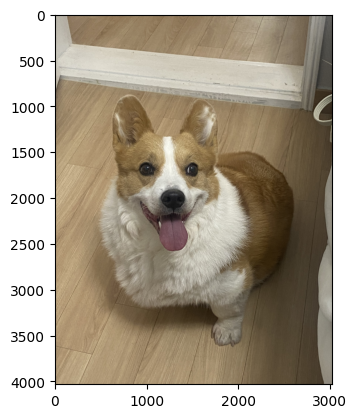

In [ ]:
# 이미지를 google drive에 마운트하여 불러옵니다
!gdown '1GmbdIn0lDZOOU0ym86GULUHGmhPZWEKz' --output dog.jpg
im = Image.open("../content/dog.jpg").rotate(270, PIL.Image.NEAREST, expand = 1)
plt.imshow(im)

In [ ]:
# 불러온 이미지를 model의 input으로 쓸 수 있도록 transform하는 과정을 거칩니다
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
im_tensor = preprocess(im)
im_tensor = im_tensor.unsqueeze(0).to(device) # 이미지를 batch 형태로 바꾸어 줌 (B x C x W x H)

print(im.size, im_tensor.shape)

(3024, 4032) torch.Size([1, 3, 224, 224])


In [ ]:
with torch.no_grad():
    output = model(im_tensor.float())

# ImageNet label 1000 개에 대한 confidence score
print(output.shape)

# softmax를 취해 확률 값으로 변환합니다
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities.shape)

# softmax를 취하면 확률값이 되므로 전체 합은 1이 됩니다
print(f'\n** Sum of the output tensors \nBefore the softmax: {sum(output[0]).item():.4f} -> After the softmax: {sum(probabilities).item():.4f}')

torch.Size([1, 1000])
torch.Size([1000])

** Sum of the output tensors 
Before the softmax: 5.0773 -> After the softmax: 1.0000


In [ ]:
# ImageNet 레이블 정보를 불러옵니다
with open("../content/imagenet_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]

# softmax 결과 가장 높은 확률을 가지는 5개의 class 출력합니다
top5_prob, top5_classes = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(f'Class: {classes[top5_classes[i]]}, Score {top5_prob[i].item():.4f}')

# Pembroke는 웰시코기 강아지의 종 이름 중 하나입니다

Class: Pembroke, Score 0.9138
Class: Cardigan, Score 0.0851
Class: Chihuahua, Score 0.0002
Class: papillon, Score 0.0001
Class: Pomeranian, Score 0.0001


## 2. 서로 다른 Backbone 비교

```
💡 목차 개요: ImageNet-1k로 학습된 weight로 initialize된 VGG 모델을 torch.hub에서 불러온 뒤 각 레이어를 거친 후의 output 값의 shape을 알아본다.
```

- 2-1. AlexNet, VGG19, 그리고 ResNet50 모델 불러오기
- 2-2. 서로 다른 Backbone 간의 비교


### 2-1 AlexNet, VGG19, 그리고 ResNet50 모델 불러오기

> `torch.hub`는 다양한 모델을 불러올 수 있을 뿐만 아니라 대표적인 데이터셋으로 학습된 weight도 함께 불러올 수 있습니다



In [ ]:
# AletNet, VGG19, ResNet18 모델을 torch.hub에서 불러옵니다
alexnet = torch.hub.load('pytorch/vision', 'alexnet', weights = 'AlexNet_Weights.DEFAULT').to(device)
vgg19 = torch.hub.load('pytorch/vision', 'vgg19', weights = 'VGG19_Weights.DEFAULT').to(device)
resnet50 = torch.hub.load('pytorch/vision', 'resnet50', weights='ResNet50_Weights.DEFAULT').to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Using cache found in /root/.cache/torch/hub/pytorch_vision_main


In [ ]:
# AlexNet의 구조
alexnet_stats = summary(alexnet, x, verbose=0)
alexnet_summary = str(alexnet_stats)
print(alexnet_summary)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 64, 55, 55]          23,296
|    └─ReLU: 2-2                         [-1, 64, 55, 55]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 192, 27, 27]         307,392
|    └─ReLU: 2-5                         [-1, 192, 27, 27]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         663,936
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         884,992
|    └─ReLU: 2-10                        [-1, 256, 13, 13]         --
|    └─Conv2d: 2-11                      [-1, 256, 13, 13]         590,080
|    └─ReLU: 2-12                        [-1, 256, 13, 13]   

In [ ]:
# resnet50의 구조
resnet50_stats = summary(resnet50, x, verbose=0)
resnet50_summary = str(resnet50_stats)
print(resnet50_summary)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

### 2-2. 서로 다른 Backbone 간의 비교

> AlexNet, VGG, ResNet 간의 파라미터 수를 비교해 보고, 같은 이미지에 대한 Prediction 결과도 비교해 본다



In [ ]:
# alexnet, vgg, resnet 간의 학습 가능한 파라미터 수 비교해보기
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("----- # of parameter -----")
print(" * AlexNet:", count_parameters(alexnet))
print(" * VGG19:", count_parameters(vgg19))
print(" * ResNet50:", count_parameters(resnet50))
print(f'==> VGG19 has {(count_parameters(vgg19))/count_parameters(alexnet):.4f} times of parameters than AlexNet')
print(f'==> ResNet50 has {(count_parameters(resnet50))/count_parameters(vgg19):.4f} times of parameters than VGG19')

----- # of parameter -----
 * AlexNet: 61100840
 * VGG19: 143667240
 * ResNet50: 25557032
==> VGG19 has 2.3513 times of parameters than AlexNet
==> ResNet50 has 0.1779 times of parameters than VGG19


In [ ]:
with torch.no_grad():
    output_alexnet = alexnet(im_tensor.float())
    output_vgg19 = vgg19(im_tensor.float())
    output_resnet50 = resnet50(im_tensor.float())

# ImageNet label 1000 개에 대한 confidence score
print("Output of AlexNet:", output_alexnet.shape)
print("Output of VGG19:", output_vgg19.shape)
print("Output of resnet50:", output_resnet50.shape)

# softmax를 취해 확률 값으로 변환합니다
prob_alexnet = torch.nn.functional.softmax(output_alexnet[0], dim=0)
prob_vgg19 = torch.nn.functional.softmax(output_vgg19[0], dim=0)
prob_resnet50 = torch.nn.functional.softmax(output_resnet50[0], dim=0)

Output of AlexNet: torch.Size([1, 1000])
Output of VGG19: torch.Size([1, 1000])
Output of resnet50: torch.Size([1, 1000])


In [ ]:
# softmax 결과 가장 높은 확률을 가지는 5개의 class 출력합니다
prob = {'alexnet':prob_alexnet, 'vgg19':prob_vgg19, 'resnet50':prob_resnet50}

for model_name in list(prob.keys()):
    top5_prob, top5_classes = torch.topk(prob[model_name], 5)
    print(f'====== {model_name} =====')
    for i in range(top5_prob.size(0)):
        print(f'Class: {classes[top5_classes[i]]}, Score {top5_prob[i].item():.4f}')

====== alexnet =====
Class: Pembroke, Score 0.8940
Class: Cardigan, Score 0.0912
Class: Chihuahua, Score 0.0073
Class: papillon, Score 0.0015
Class: toilet tissue, Score 0.0015
====== vgg19 =====
Class: Pembroke, Score 0.9071
Class: Cardigan, Score 0.0922
Class: toilet tissue, Score 0.0001
Class: Chihuahua, Score 0.0001
Class: papillon, Score 0.0000
====== resnet50 =====
Class: Pembroke, Score 0.0037
Class: Cardigan, Score 0.0034
Class: basenji, Score 0.0028
Class: Staffordshire bullterrier, Score 0.0028
Class: Chihuahua, Score 0.0025


#Reference
- <a href='https://pytorch.org/hub/pytorch_vision_vgg/'>torch.hub 모델 활용</a>
- <a href='https://pypi.org/project/torch-summary/'>torch summary 문서</a>


## Required Package

> torch == 2.0.1

> torchvision == 0.15.2